这个章节讲的主要是 slam的后端优化

前面主要讲的不同相机前端，单目，双目，深度，在不同算法下的处理
但是这处理的 例如相机的姿态和位置可能是不连续的散点图

可能 前端算的 位置是近似的一条曲线附近的 高斯分布，后端要做的是就是将这些不好的的数据偏移带来的影响最小化

去拟合真实的相机姿态和位置等关键信息

方法
最小二乘法
这个方法就是最简单的，就是用最小二乘法拟合出一个曲线，然后再用曲线来拟合数据
单前提是得先知道 曲线的形式，然后再拟合

不知道的话就得用多项式方程等去拟合，非线性最小二乘
（不知道就用多项式拟合，同时也可以拟合其他非线性函数）

其实也不用一定要一个方程曲线，只要是光滑的曲线就可以

本质还是求个极小值问题


这个优化一定是知道自己一定点信息后才能 优化

优化的两种方法 高斯牛顿法 和 列文伯格-马夸尔特方法


In [ ]:
# 下面是AI总结的额，总之很专业额


SLAM后端优化与最小二乘法的关系：
是的，高斯牛顿法（Gauss-Newton）和列文伯格-马夸尔特方法（Levenberg-Marquardt，简称LM）主要是用于解决非线性最小二乘问题的优化方法。在SLAM的后端优化中，我们通常需要最小化一个非线性的误差函数，这正是这些方法所针对的问题。

这两种方法的基本原理和实现：
高斯牛顿法：

原理：通过对误差函数进行一阶泰勒展开，将非线性最小二乘问题近似为线性最小二乘问题。
实现步骤：
计算雅可比矩阵J
求解正规方程 (J^T J)Δx = -J^T f(x)
更新参数 x = x + Δx
重复上述步骤直到收敛
列文伯格-马夸尔特方法：

原理：结合了高斯牛顿法和梯度下降法的特点，引入了阻尼因子λ来调节优化步长。
实现步骤：
计算雅可比矩阵J
求解方程 (J^T J + λI)Δx = -J^T f(x)
如果误差减小，接受这一步，减小λ；否则，增大λ并重新计算
更新参数 x = x + Δx
重复上述步骤直到收敛
优化的滞后性：
SLAM后端优化确实存在一定的滞后性，主要原因包括：

计算复杂度：优化涉及大量矩阵运算，特别是在大规模SLAM问题中。
迭代性质：这些方法通常需要多次迭代才能收敛。
数据积累：后端优化通常在积累了一定量的数据后才进行。
然而，这种滞后性并不总是一个问题：

实时性要求：对于需要实时性的应用，可以采用滑动窗口优化或增量优化等技术。
离线处理：对于一些应用，可以在数据采集完成后进行离线优化。
并行计算：可以利用并行计算技术来加速优化过程。
总的来说，高斯牛顿法和列文伯格-马夸尔特方法是解决SLAM后端优化问题的有效工具。虽然存在一定的滞后性，但通过合适的策略和技术，我们可以在精度和实时性之间找到平衡。在实际应用中，选择哪种方法通常取决于具体问题的特性和系统的需求。

Generating data:
0.00 3.56
0.01 4.14
0.02 3.71
0.03 2.70
0.04 3.22
0.05 2.77
0.06 2.92
0.07 1.28
0.08 2.88
0.09 2.10
0.10 2.52
0.11 3.59
0.12 3.58
0.13 1.81
0.14 3.06
0.15 3.26
0.16 2.19
0.17 3.69
0.18 4.54
0.19 2.24
0.20 4.50
0.21 4.36
0.22 4.18
0.23 6.04
0.24 6.48
0.25 5.27
0.26 5.64
0.27 5.85
0.28 5.75
0.29 5.64
0.30 6.07
0.31 4.85
0.32 6.24
0.33 6.08
0.34 5.99
0.35 7.49
0.36 4.52
0.37 6.09
0.38 3.97
0.39 7.86
0.40 5.40
0.41 6.64
0.42 11.62
0.43 7.69
0.44 7.75
0.45 9.29
0.46 9.13
0.47 7.45
0.48 8.18
0.49 8.74
0.51 9.46
0.52 10.17
0.53 10.80
0.54 9.75
0.55 11.36
0.56 10.22
0.57 8.36
0.58 11.77
0.59 10.47
0.60 12.48
0.61 12.53
0.62 13.92
0.63 13.29
0.64 15.76
0.65 14.84
0.66 15.69
0.67 17.52
0.68 16.34
0.69 17.28
0.70 18.05
0.71 18.38
0.72 19.08
0.73 20.89
0.74 20.69
0.75 20.84
0.76 21.33
0.77 23.66
0.78 24.06
0.79 24.47
0.80 24.53
0.81 26.92
0.82 26.09
0.83 28.79
0.84 30.15
0.85 31.22
0.86 30.89
0.87 32.10
0.88 35.10
0.89 35.53
0.90 37.20
0.91 38.68
0.92 39.09
0.93 41.96
0.94 44.23
0

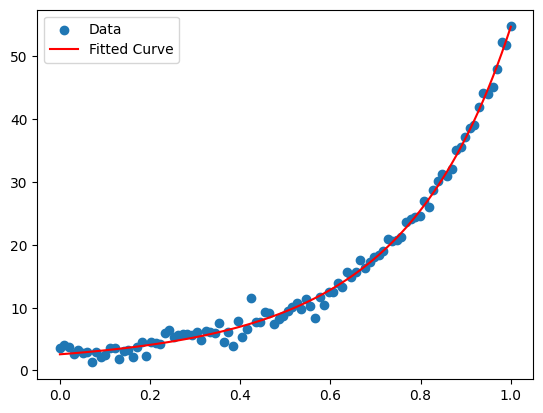

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# 定义模型函数
def model_func(x, a, b, c):
    return np.exp(a * x**2 + b * x + c)

# 定义残差函数
def residual_func(params, x, y):
    a, b, c = params
    return y - model_func(x, a, b, c)

# 主函数
def main():
    # 真实参数值
    a, b, c = 1.0, 2.0, 1.0
    N = 100  # 数据点数
    w_sigma = 1.0  # 噪声Sigma值

    # 生成数据
    x_data = np.linspace(0, 1, N)
    y_data = model_func(x_data, a, b, c) + np.random.normal(0, w_sigma, N)

    print("Generating data:")
    for x, y in zip(x_data, y_data):
        print(f"{x:.2f} {y:.2f}")

    # 初始参数估计
    initial_guess = [0.0, 0.0, 0.0]

    # 使用least_squares进行优化
    # 这里把构建 最小二乘问题和 配置求解器直接调用了函数，所以这么简单，建议直接看 源码
    result = least_squares(residual_func, initial_guess, args=(x_data, y_data))

    # 输出结果
    print("\nOptimization result:")
    print(result.message)
    print(f"Estimated parameters: a={result.x[0]:.6f}, b={result.x[1]:.6f}, c={result.x[2]:.6f}")

    # 绘制结果
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(x_data, model_func(x_data, *result.x), 'r-', label='Fitted Curve')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


Generating data:
0.00 4.60
0.01 1.43
0.02 1.56
0.03 3.86
0.04 1.78
0.05 4.96
0.06 2.67
0.07 2.40
0.08 5.14
0.09 4.77
0.10 5.23
0.11 4.34
0.12 2.65
0.13 5.51
0.14 3.41
0.15 4.57
0.16 4.80
0.17 3.79
0.18 4.66
0.19 5.06
0.20 4.62
0.21 3.25
0.22 4.75
0.23 5.89
0.24 3.99
0.25 4.65
0.26 4.49
0.27 6.90
0.28 5.86
0.29 5.73
0.30 4.69
0.31 6.15
0.32 5.09
0.33 5.95
0.34 5.44
0.35 6.92
0.36 7.00
0.37 6.39
0.38 7.18
0.39 5.89
0.40 5.69
0.41 7.83
0.42 7.77
0.43 8.46
0.44 10.44
0.45 9.24
0.46 7.63
0.47 9.92
0.48 7.75
0.49 8.88
0.51 9.56
0.52 11.64
0.53 9.50
0.54 9.74
0.55 10.80
0.56 10.58
0.57 12.73
0.58 10.90
0.59 11.22
0.60 12.33
0.61 12.69
0.62 15.56
0.63 15.03
0.64 14.64
0.65 13.82
0.66 16.40
0.67 15.08
0.68 15.09
0.69 18.40
0.70 18.13
0.71 19.35
0.72 19.40
0.73 20.61
0.74 19.81
0.75 20.16
0.76 22.64
0.77 21.95
0.78 22.89
0.79 23.99
0.80 25.37
0.81 25.94
0.82 25.89
0.83 27.65
0.84 27.14
0.85 31.10
0.86 30.04
0.87 31.75
0.88 34.17
0.89 34.70
0.90 38.37
0.91 36.98
0.92 40.04
0.93 41.31
0.94 41.83
0

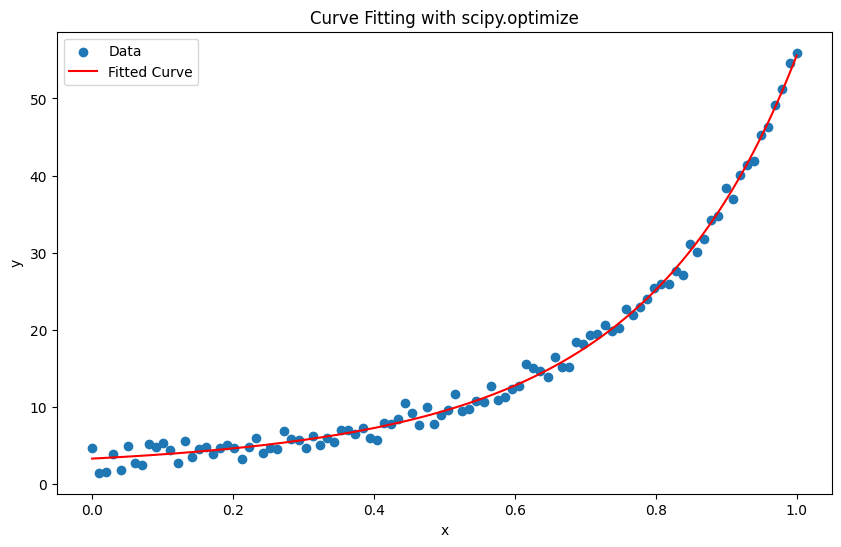

In [10]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

def model(x, params):
    return np.exp(params[0] * x**2 + params[1] * x + params[2])

def residuals(params, x, y):
    return y - model(x, params)

def main():
    # 真实参数
    a, b, c = 1.0, 2.0, 1.0
    N = 100  # 数据点数量
    w_sigma = 1.0  # 噪声标准差

    # 生成数据
    x_data = np.linspace(0, 1, N)
    y_data = model(x_data, [a, b, c]) + np.random.normal(0, w_sigma, N)

    print("Generating data:")
    for x, y in zip(x_data, y_data):
        print(f"{x:.2f} {y:.2f}")

    # 初始参数猜测
    initial_guess = [0.0, 0.0, 0.0]

    # 执行优化
    result = least_squares(residuals, initial_guess, args=(x_data, y_data))

    # 输出结果
    print("\nOptimization results:")
    print(f"Estimated parameters: a={result.x[0]:.6f}, b={result.x[1]:.6f}, c={result.x[2]:.6f}")

    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.scatter(x_data, y_data, label='Data')
    x_plot = np.linspace(0, 1, 1000)
    y_plot = model(x_plot, result.x)
    plt.plot(x_plot, y_plot, 'r-', label='Fitted Curve')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve Fitting with scipy.optimize')
    plt.show()

if __name__ == "__main__":
    main()


建议 直接调用库额，别像大佬一样 手搓 ，图优化有点抽象额，简单的说就是 将最小二乘法映射到图空间中，来优化 点和边的值，使得边最终收敛指向对应的 目标值点